# Computational Game Theory Group Assignment: Evolutionary Dynamics  of N-person Hawk-Dove games
Sam Vanspringel - 0580462 - VUB

Hendrik Temmerman - 0568045 - VUB

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import egttools as egt
import nashpy as nash
import scipy

from scipy.special import comb

from egttools.plotting.helpers import (
    xy_to_barycentric_coordinates, calculate_stationary_points, calculate_stability
)
from egttools.helpers.vectorized import (
    vectorized_replicator_equation, vectorized_barycentric_to_xy_coordinates
)

from egttools.plotting import Simplex2D

from egttools.analytical import replicator_equation_n_player
from egttools.analytical.utils import (calculate_gradients, find_roots, check_replicator_stability_pairwise_games,)
from egttools.plotting import plot_gradients
from pprint import pprint

In [77]:
nb_strategies = 2

# 1. Infinite Populations

In [78]:
# define the parameters
R = 1.0
N = 5

#n_hawks = np.random.randint(0, N)
#n_doves = N - n_hawks

#x_hawks = n_hawks/N
#x_doves = 1-x_hawks

n_steps = 100

In [79]:
# Payoff hawks
def P_H(amount_hawks, c_h):
    P_H = 0
    total_hawks = amount_hawks + 1
    if total_hawks > 0:
        P_H = (R - amount_hawks*c_h) / total_hawks
    return P_H

# Payoff doves
def P_D(amount_hawks):
    if amount_hawks == 0:
        P_D = R/N
    elif amount_hawks > 0:
        P_D = 0.0
    return P_D

In [80]:
# Fitness hawks
def average_fitness_hawks(N, x_fraction, c_h):
    average_fitness = 0.0
    for i in range(N):
        average_fitness += comb(N-1, i)*(x_fraction**i)*((1-x_fraction)**(N-1-i))*P_H(i, c_h)
    return average_fitness
    
# Fitness doves
def average_fitness_doves(N, x_fraction):
    average_fitness = 0.0
    for i in range(N):
        average_fitness += comb(N-1, i)*(x_fraction**i)*((1-x_fraction)**(N-1-i))*P_D(i+1)
    return average_fitness

# Fitness average
def average_fitness_population(x_hawks, x_doves, fitness_hawks, fitness_doves):
    return (x_hawks * fitness_hawks) + (x_doves * fitness_doves)
    


In [81]:
#Experiment (Figure: 1.A)

c_h_results = np.empty((3, n_steps))
hawk_cost = np.linspace(0, 1, num=n_steps, dtype=np.float64)

for index, c_h in enumerate([0.1, 0.5, 0.9]):
    
    x_dot = np.empty(n_steps)

    for i in range(len(hawk_cost)):
        x = hawk_cost[i]
        fitness_doves = average_fitness_doves(N, x)
        fitness_hawks = average_fitness_hawks(N, 1-x, c_h)

        x_dot[i] = x*(1-x)*(fitness_doves - fitness_hawks)
        
    c_h_results[index] = x_dot


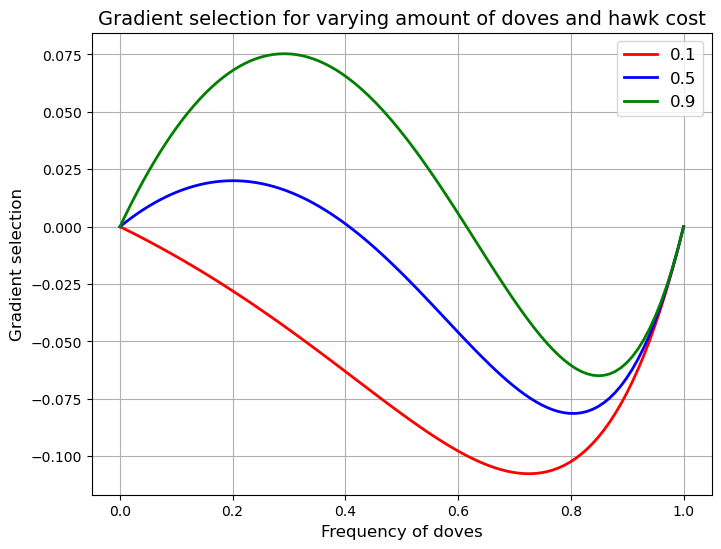

In [82]:
#Plotting
labels = ["0.1", "0.5", "0.9"]
colors = ["red", "blue", "green"]

# Plot each array
plt.figure(figsize=(8, 6))
for i, values in enumerate(c_h_results):
    plt.plot(hawk_cost, values, label=labels[i], color=colors[i], linewidth=2)

# Add labels, legend, and grid
plt.xlabel("Frequency of doves", fontsize=12)
plt.ylabel("Gradient selection", fontsize=12)
plt.title("Gradient selection for varying amount of doves and hawk cost", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()

In [83]:
def find_equilibria_indexes(run):
    eq = []
    for i in range(run.shape[0]):
        gradient = run[i]
        if gradient == 0.0:
            eq.append(i)
        if i < len(run):
            if run[i] < 0 and run[i + 1] > 0:
                    eq.append(i)
            if run[i] > 0 and run[i + 1] < 0:
                    eq.append(i)
    return eq


hawk_cost = np.linspace(0, 1, num=n_steps, dtype=np.float64)
N_values = [5,10,20,50,100]
eq_results =  np.empty((len(N_values), n_steps))

for i_N, N in enumerate(N_values):
    eq = []
    for index, c_h in enumerate(np.linspace(0, 1, num=n_steps, dtype=np.float64)):
        
        x_dot = np.empty(n_steps)

        for i in range(len(hawk_cost)):
            x = hawk_cost[i]
            fitness_doves = average_fitness_doves(N, x)
            fitness_hawks = average_fitness_hawks(N, 1-x, c_h)

            x_dot[i] = x*(1-x)*(fitness_doves - fitness_hawks)

        equilibria = find_equilibria_indexes(x_dot)  
        
        if len(equilibria) > 2:
            eq.append(hawk_cost[equilibria[1]])
        else: 
            eq.append(hawk_cost[equilibria[0]])

    eq_results[i_N] = eq

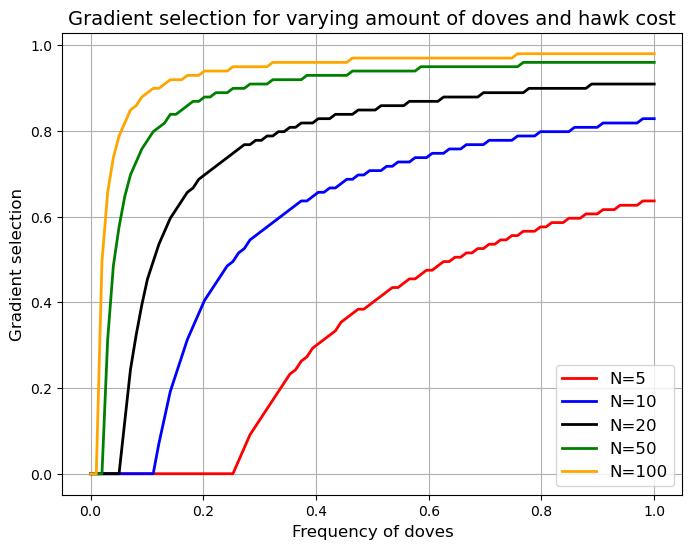

In [84]:

#Plotting
labels = ["N=5", "N=10", "N=20", "N=50", "N=100"]
colors = ["red", "blue", "black", "green", "orange"]

# Plot each array
plt.figure(figsize=(8, 6))
for i, values in enumerate(eq_results):
    plt.plot(hawk_cost, values, label=labels[i], color=colors[i], linewidth=2)

# Add labels, legend, and grid
plt.xlabel("Frequency of doves", fontsize=12)
plt.ylabel("Gradient selection", fontsize=12)
plt.title("Gradient selection for varying amount of doves and hawk cost", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()

In [9]:
# Parameters
R = 1  
N = 5
c_H_values = [0.1, 0.5]  
Z_values = [10, 20, 100]  
w = 1  

In [10]:
def gradient_of_selection(k, Z, c_H, N, w):

    fraction = k/Z
    f_d = average_fitness_doves(N, fraction)
    f_h = average_fitness_hawks(N, (1-fraction), c_H)

    T_plus = fraction * ((Z - k) / Z) * (1 / (1 + np.exp(-w * (f_d - f_h))))
    T_minus = fraction * ((Z - k) / Z) * (1 / (1 + np.exp(-w * (f_h - f_d))))

    gradient = T_plus - T_minus
    return gradient

def calculate_gradients_figure_2A(Z, c_H, N, w):
    
    k_values = np.arange(Z + 1)
    g_values = np.empty(len(k_values))
    
    for i, k in enumerate(k_values):
        g_values[i] = gradient_of_selection(k, Z, c_H, N, w)

    X_as = k_values / Z
    
    return X_as, g_values

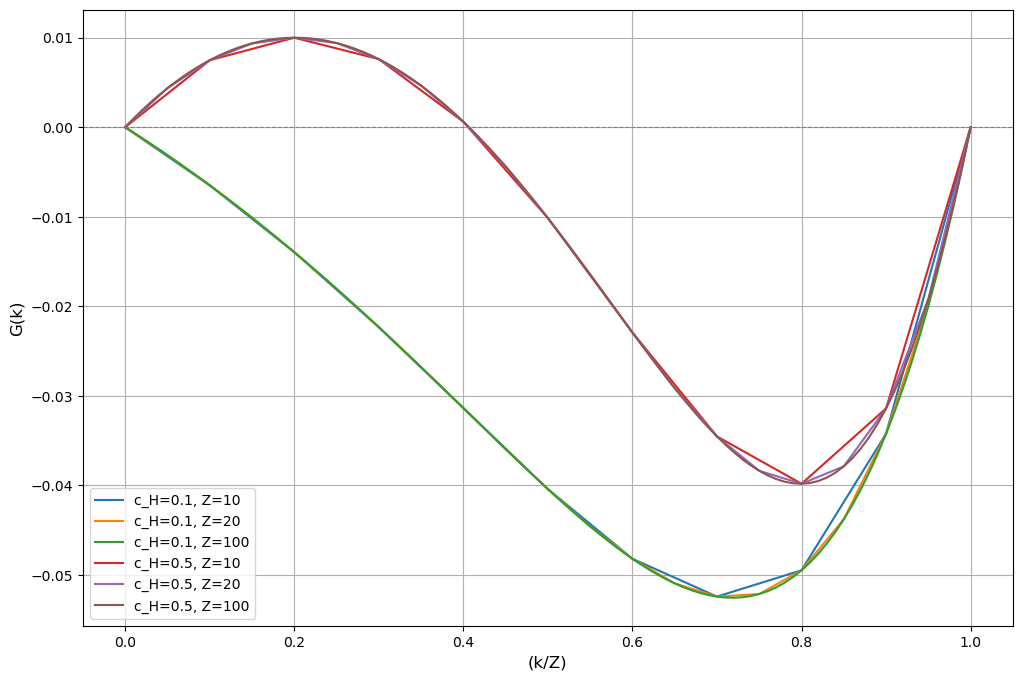

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))

for c_H in c_H_values:
    for Z in Z_values:
        X_as, g_values = calculate_gradients_figure_2A(Z, c_H, N, w)
        ax.plot(X_as, g_values, label=f"c_H={c_H}, Z={Z}")

# Plot details
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax.set_xlabel("(k/Z)", fontsize=12)
ax.set_ylabel("G(k)", fontsize=12)
ax.legend()
ax.grid()
plt.show()

In [12]:
Z = 100
R = 1
w = 1
hawk_cost = np.linspace(0, 1, num=n_steps, dtype=np.float64)
n_steps = 100

In [ ]:
def calculate_gradients_figure_2B(Z, N, w):
    eq = []
    for index, c_H in enumerate(np.linspace(0, 1, num=n_steps, dtype=np.float64)):
        X_as, g_values = calculate_gradients_figure_2A(Z, c_H, N, w)
        
        equilibria = find_equilibria_indexes(g_values)  
        
        if len(equilibria) > 2:
            eq.append(hawk_cost[equilibria[1]])
        else: 
            eq.append(hawk_cost[equilibria[0]])

    return eq

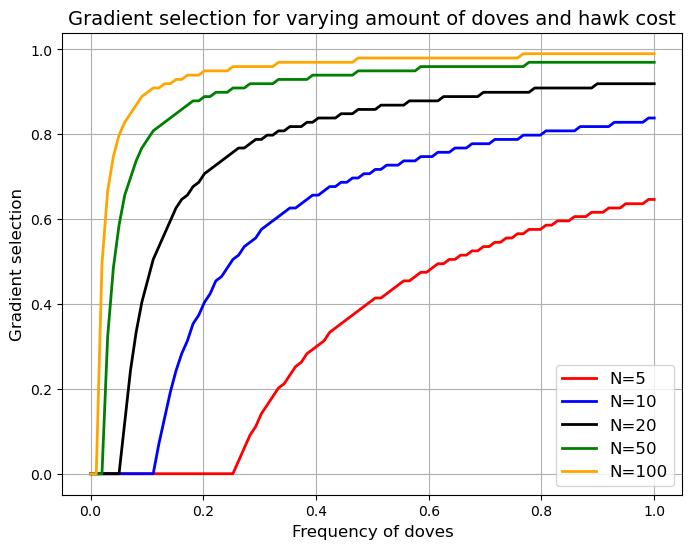

In [14]:
#Plotting
labels = ["N=5", "N=10", "N=20", "N=50", "N=100"]
colors = ["red", "blue", "black", "green", "orange"]
N_values = [5,10,20,50,100]


# Plot each array
plt.figure(figsize=(8, 6))
for i, N in enumerate(N_values):
    values = calculate_gradients_figure_2B(Z, N, w)
    plt.plot(hawk_cost, values, label=labels[i], color=colors[i], linewidth=2)

  

# Add labels, legend, and grid
plt.xlabel("Frequency of doves", fontsize=12)
plt.ylabel("Gradient selection", fontsize=12)
plt.title("Gradient selection for varying amount of doves and hawk cost", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# Payoff hawks
def P_H(amount_hawks, c_h, T):
    P_H = 0
    total_hawks = amount_hawks + 1
    if total_hawks > N * T:
        P_H = (R - amount_hawks*c_h) / total_hawks
    return P_H

# Payoff doves
def P_D(amount_doves, c_d, T):
    P_D = 0
    total_doves = amount_doves + 1
    if total_doves < N * T:
        P_D = (R - amount_doves*c_d) / total_doves
    return P_D

In [ ]:
# Fitness hawks
def average_fitness_hawks(N, x_fraction, c_h, T):
    average_fitness = 0.0
    for i in range(N):
        average_fitness += comb(N-1, i)*(x_fraction**i)*((1-x_fraction)**(N-1-i))*P_H(i, c_h, T)
    return average_fitness
    
# Fitness doves
def average_fitness_doves(N, x_fraction, c_d, T):
    average_fitness = 0.0
    for i in range(N):
        average_fitness += comb(N-1, i)*(x_fraction**i)*((1-x_fraction)**(N-1-i))*P_D(i+1, c_d, T)
    return average_fitness

# Figure 3

In [124]:
# Parameters
N = 5 
R = 1.0
n_steps = 100

In [158]:
# Payoff hawks
def P_H(amount_hawks, c_h, T):
    P_H = 0
    total_hawks= amount_hawks + 1
    threshold = N - N*T
    if total_hawks > threshold:
        P_H = (R - amount_hawks*c_h) / total_hawks 
    return P_H

# Payoff doves
def P_D(amount_hawks, c_d,  T):
    P_D = 0
    total_hawks= amount_hawks + 1
    threshold = N - N*T
    if total_hawks <= threshold:
        amount_doves = N - total_hawks
        P_D = (R - (amount_doves - 1) * c_d) / total_hawks
    return P_D


In [140]:
# Fitness hawks
def average_fitness_hawks(N, x_fraction, c_h, T):
    average_fitness = 0.0
    for i in range(N):
        average_fitness += comb(N-1, i)*(x_fraction**i)*((1-x_fraction)**(N-1-i))*P_H(i, c_h, T)
    return average_fitness
    
# Fitness doves
def average_fitness_doves(N, x_fraction, c_d, T):
    average_fitness = 0.0
    for i in range(N):
        average_fitness += comb(N-1, i)*(x_fraction**i)*((1-x_fraction)**(N-1-i))*P_D(i, c_d, T)
    return average_fitness

In [33]:
def find_equilibria_indexes(run):
    eq = []
    for i in range(run.shape[0]):
        gradient = run[i]
        if gradient == 0.0:
            eq.append(i)
        if i < len(run)-1:
            if run[i] < 0 and run[i + 1] > 0:
                    eq.append(i)
            if run[i] > 0 and run[i + 1] < 0:
                    eq.append(i)
    return eq

In [151]:
def figure3A(T, c_d):

    hawk_cost = np.linspace(0, 1, num=n_steps, dtype=np.float64)
    hawk_frequency = np.linspace(0, 1, num=n_steps, dtype=np.float64)
    fraction_dove = []

    for c_h in hawk_cost:
        
        x_dot = np.empty(n_steps)

        for i in range(len(hawk_frequency)):
            x = hawk_frequency[i]
            fitness_doves = average_fitness_doves(N, x, c_d, T)
            fitness_hawks = average_fitness_hawks(N, 1-x, c_h, T)
            x_dot[i] = x * (1 - x) * (fitness_doves - fitness_hawks)

        equilibria = find_equilibria_indexes(x_dot)  
        
        if len(equilibria) > 2:
            fraction_dove.append(hawk_frequency[equilibria[1]])
        else: 
            fraction_dove.append(hawk_frequency[equilibria[0]])

    return fraction_dove, hawk_cost


def figure3B(T, c_h):

    dove_cost = np.linspace(0, 1, num=n_steps, dtype=np.float64)
    dove_frequency = np.linspace(0, 1, num=n_steps, dtype=np.float64)
    fraction_dove = []

    for c_d in dove_cost:
        
        x_dot = np.empty(n_steps)

        for i in range(len(dove_frequency)):
            x = dove_frequency[i]
            fitness_doves = average_fitness_doves(N, x, c_d, T)
            fitness_hawks = average_fitness_hawks(N, 1-x, c_h, T)

            x_dot[i] = x*(1-x)*(fitness_doves - fitness_hawks)

        equilibria = find_equilibria_indexes(x_dot)  
        
        if len(equilibria) > 2:
            fraction_dove.append(dove_frequency[equilibria[1]])
        else: 
            fraction_dove.append(dove_frequency[equilibria[0]])

    return fraction_dove, dove_cost

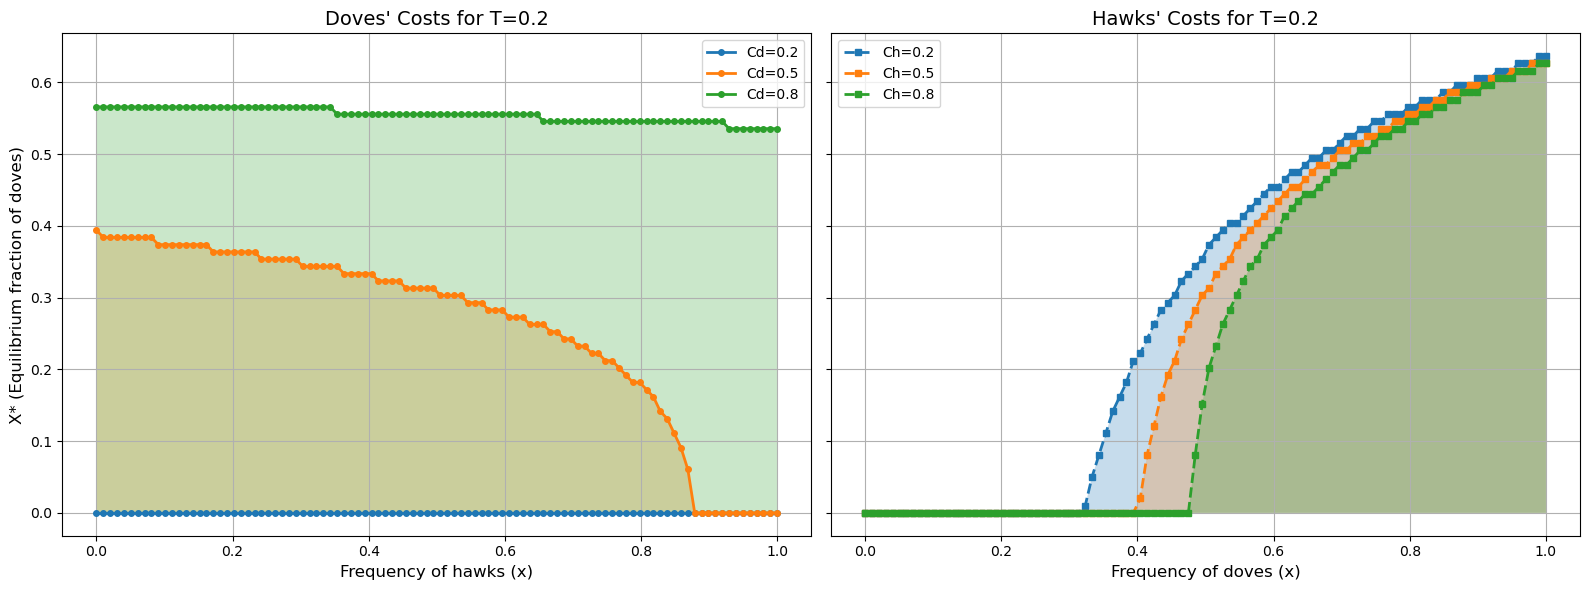

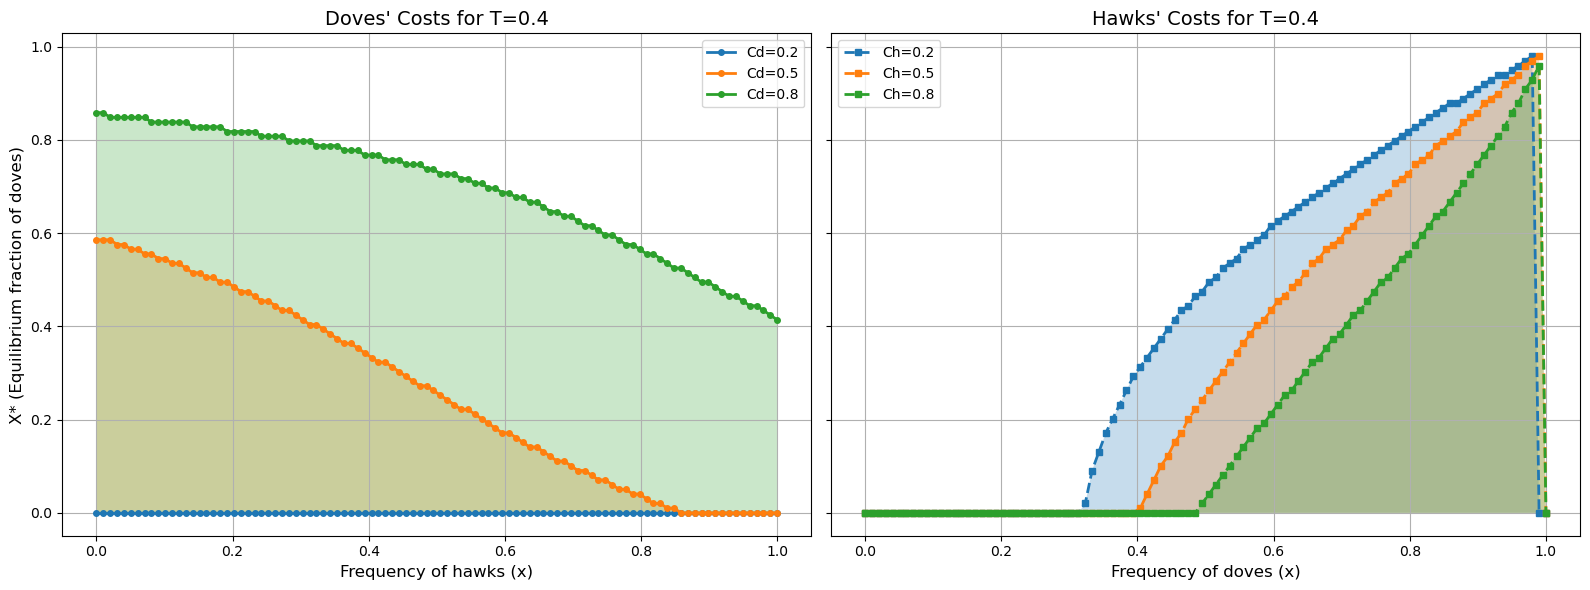

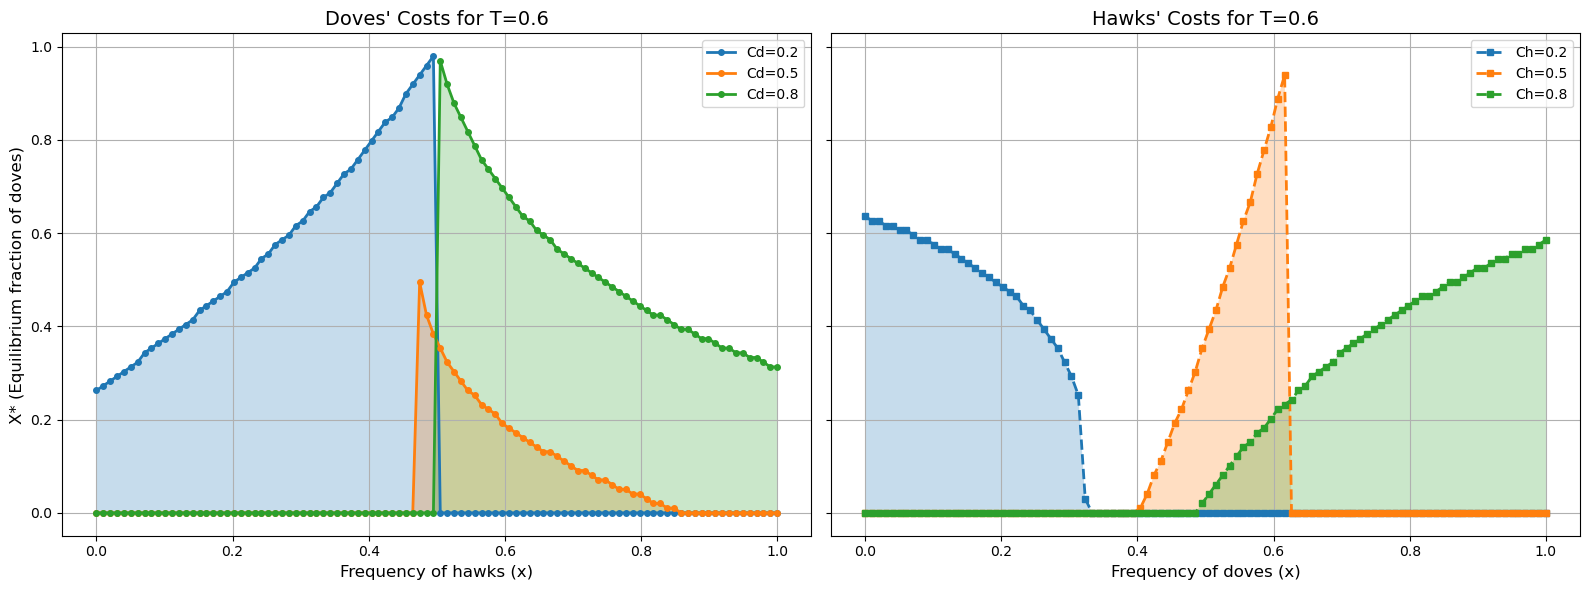

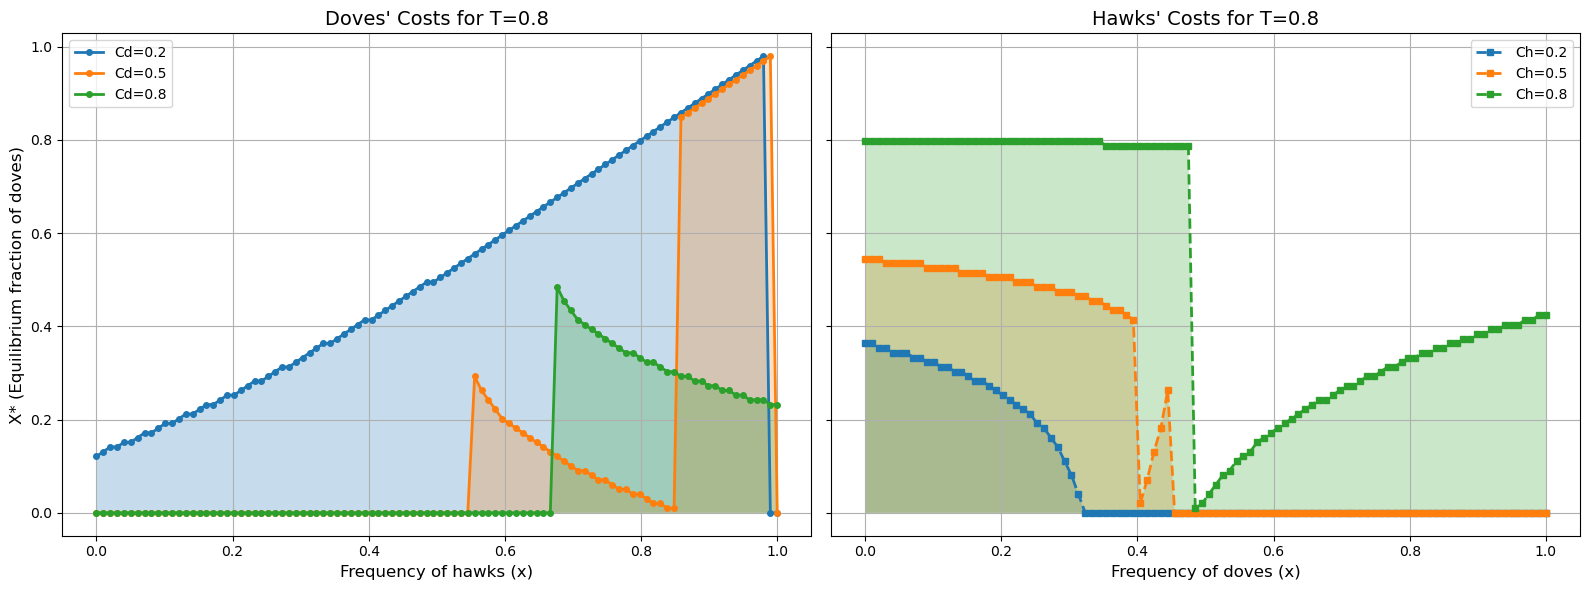

In [159]:
T_labels = ["T=0.2", "T=0.4", "T=0.6", "T=0.8"]
T_values = [0.2, 0.4, 0.6, 0.8]

Doves_Costs_labels = ["Cd=0.2", "Cd=0.5", "Cd=0.8"]
Doves_Costs = [0.2, 0.5, 0.8]

Hawks_Costs_labels = ["Ch=0.2", "Ch=0.5", "Ch=0.8"]
Hawks_Costs = [0.2, 0.5, 0.8]


def plot_figure3_side_by_side(T_values, Doves_Costs, Doves_Costs_labels, Hawks_Costs, Hawks_Costs_labels):
    for t_idx, T in enumerate(T_values):
        fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

        #Doves
        for d_idx, c_d in enumerate(Doves_Costs):
            y_as, x_as = figure3A(T, c_d)  
            axes[0].plot(x_as, y_as, label=Doves_Costs_labels[d_idx],
                         linestyle='-', marker='o', markersize=4, linewidth=2)
            axes[0].fill_between(x_as, 0, y_as, alpha=0.25)

        axes[0].set_title(f"Doves' Costs for {T_labels[t_idx]}", fontsize=14)
        axes[0].set_xlabel("Frequency of hawks (x)", fontsize=12)
        axes[0].set_ylabel("X* (Equilibrium fraction of doves)", fontsize=12)
        axes[0].legend(fontsize=10, loc="best")
        axes[0].grid(True)

        # Hawk's
        for h_idx, c_h in enumerate(Hawks_Costs):
            y_as, x_as = figure3B(T, c_h)  
            axes[1].plot(x_as, y_as, label=Hawks_Costs_labels[h_idx],
                         linestyle='--', marker='s', markersize=4, linewidth=2)
            axes[1].fill_between(x_as, 0, y_as, alpha=0.25)

        axes[1].set_title(f"Hawks' Costs for {T_labels[t_idx]}", fontsize=14)
        axes[1].set_xlabel("Frequency of doves (x)", fontsize=12)
        axes[1].legend(fontsize=10, loc="best")
        axes[1].grid(True)

        plt.tight_layout()
        plt.show()

plot_figure3_side_by_side(T_values, Doves_Costs, Doves_Costs_labels, Hawks_Costs, Hawks_Costs_labels)


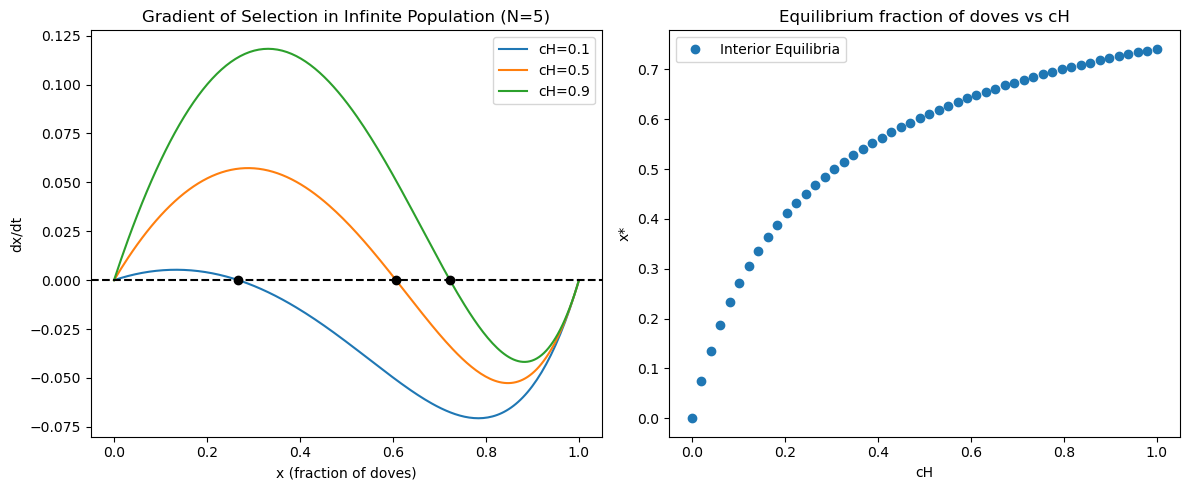

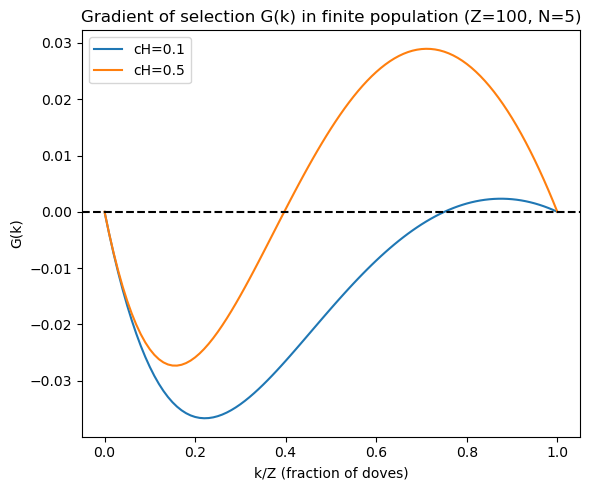

In [ ]:
def P_H_T(amount_hawks, c_h, T, N):
    P_H = 0
    total_hawks= amount_hawks + 1
    amount_doves = N - total_hawks
    if amount_doves/N < T:
        P_H = (R - amount_hawks*c_h) / total_hawks 
    return P_H

# Payoff doves
def P_D_T(amount_hawks, c_d,  T, N):
    P_D = 0
    total_hawks = amount_hawks + 1
    amount_doves = N - total_hawks
    if amount_doves/N >= T:
        P_D = R - (total_hawks * c_d) / amount_doves
    return P_D


def average_fitness_hawks_T(N, x_fraction, c_h, T):
    average_fitness = 0.0
    for i in range(N):
        average_fitness += comb(N-1, i)*(x_fraction**i)*((1-x_fraction)**(N-1-i))*P_H_T(i, c_h, T, N)
    return average_fitness
    
# Fitness doves
def average_fitness_doves_T(N, x_fraction, c_d, T):
    average_fitness = 0.0
    for i in range(N):
        average_fitness += comb(N-1, i)*(x_fraction**i)*((1-x_fraction)**(N-1-i))*P_D_T(i, c_d, T, N)
    return average_fitness

n_steps = 100
costs_hawk = np.linspace(0, 1, num=n_steps, dtype=np.float64)
costs_dove = [0.2, 0.5, 0.8]
dove_fractions = np.linspace(0, 1, num=n_steps, dtype=np.float64)
T = 0.2
N = 5
results =  np.empty((len(costs_dove), n_steps))

for i_c_d, c_d in enumerate(costs_dove):
    equilibria_results = np.empty(n_steps)
    gradients = np.empty(n_steps)
    for i_c_h, c_h in enumerate(costs_hawk):
        x_dot = np.empty(n_steps)

        for i in range(len(dove_fractions)):
            x = dove_fractions[i]
            fitness_doves = average_fitness_doves_T(N, x, c_d, T)
            fitness_hawks = average_fitness_hawks_T(N, 1-x, c_h, T)

            x_dot[i] = x*(1-x)*(fitness_doves - fitness_hawks)

        equilibria = find_equilibria_indexes(x_dot)  
        print(equilibria)
        
        if len(equilibria) > 2:
            gradients[i_c_h] = dove_fractions[equilibria[1]]
        else: 
            gradients[i_c_h] = dove_fractions[equilibria[1]]

    results[i_c_d] = gradients



[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 99]
1.0
[0, 

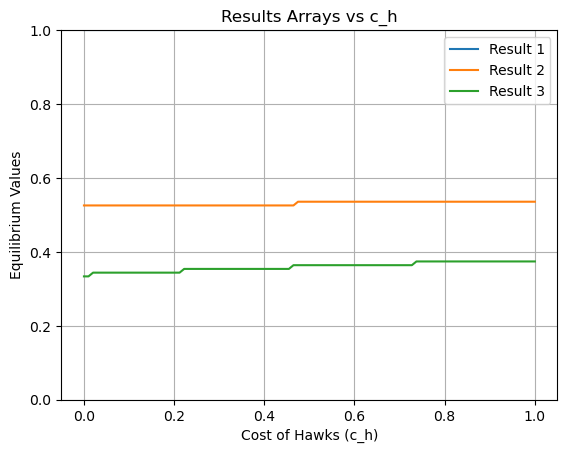

In [91]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure this uses your actual data
n_steps = 100  # Number of steps

# Plot all arrays in the results on one plot
plt.figure()
for i, data in enumerate(results):
    plt.plot(costs_hawk, data, label=f'Result {i+1}')
    
plt.xlabel('Cost of Hawks (c_h)')
plt.ylabel('Equilibrium Values')
plt.title('Results Arrays vs c_h')
plt.ylim(0, 1)  # Set y-axis scale to 0 to 1
plt.legend()
plt.grid(True)
plt.show()